In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from scipy import optimize, ndimage
from sklearn.base import BaseEstimator, ClassifierMixin


In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

def split_Raman_af(X):
    """
    Removing spikes from the data to extract the autofluorescence.
    This is done by applying smoothing filter to the data and then taking the min of the smoothing filter and original data.
    """
    a = X
    # remove spikes from data
    a1 = ndimage.gaussian_filter(a, (0, 10), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 20), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 30), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 40), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 50), mode='nearest')
    a = np.min([a, a1], axis=0)

    a1 = ndimage.gaussian_filter(a, (0, 60), mode='nearest')
    a = np.min([a, a1], axis=0)
    
    # Restore Edges
    c = 50
    a[:,:c] = X[:,:c]
    a[:,-c:] = X[:,-c:]
    
    #smooth everyting
    for _ in range(100):
        a1 = ndimage.gaussian_filter(a, (0, 10), mode='nearest')
        a = np.min([a, a1], axis=0)
        a[:,0] = X[:,0]
        a[:,-1] = X[:,-1]
        
    return X-a, a

def smoothing(X, smooth=5, spike_width=3):
    """
    Only remove noise from low noise to signal area's to maintain the intensity of the spikes.
    Noise is removed with a gaussian filter in spectral dimension.
    """
    grad = ndimage.gaussian_filter(X, (0, 1), order=1)
    grad_abs = np.abs(grad)
    grad_abs_sm = ndimage.gaussian_filter(grad_abs, (0, 1))
    mean_grad = np.mean(grad_abs, 1) + np.std(grad_abs, 1)
    noise_to_signal_quality = ndimage.gaussian_filter((grad_abs_sm.T < mean_grad).T.astype(float), (0, spike_width))
    return noise_to_signal_quality * ndimage.gaussian_filter(X, (0,smooth)) + (1-noise_to_signal_quality) * X

def stack_raman_lf(ram, fl):
#     return unit_vector_norm(np.hstack((fl, ram)))    
    return np.hstack((unit_vector_norm(fl), unit_vector_norm(ram)))

In [4]:
wavelength = np.load("../data/Raman/wavelength.npy", 'r')

files = ['blue0', 'blue1', 'blue2', 'blue3', 'blue4',
         'green0', 'green1', 'green2',
         'red0', 'red1', 'red2']

ref_vectors = {}
for file in files:
    ref_vectors[file] = np.load(f"../data/Raman/{file}.npy", 'r')

In [5]:
wave = np.hstack((wavelength - 2000, wavelength))

blue  = np.array([value for key, value in ref_vectors.items() if 'blue'  in key])
red   = np.array([value for key, value in ref_vectors.items() if 'red'   in key])
green = np.array([value for key, value in ref_vectors.items() if 'green' in key])
    
b  = smoothing(blue , 10, 25)
r   = smoothing(red  , 5, 2)
g = smoothing(green, 5, 2)

blue  = stack_raman_lf(*split_Raman_af(b))
red   = stack_raman_lf(*split_Raman_af(r))
green = stack_raman_lf(*split_Raman_af(g))

avg_b = np.mean(blue, 0)
avg_r = np.mean(red, 0)
avg_g = np.mean(green, 0)

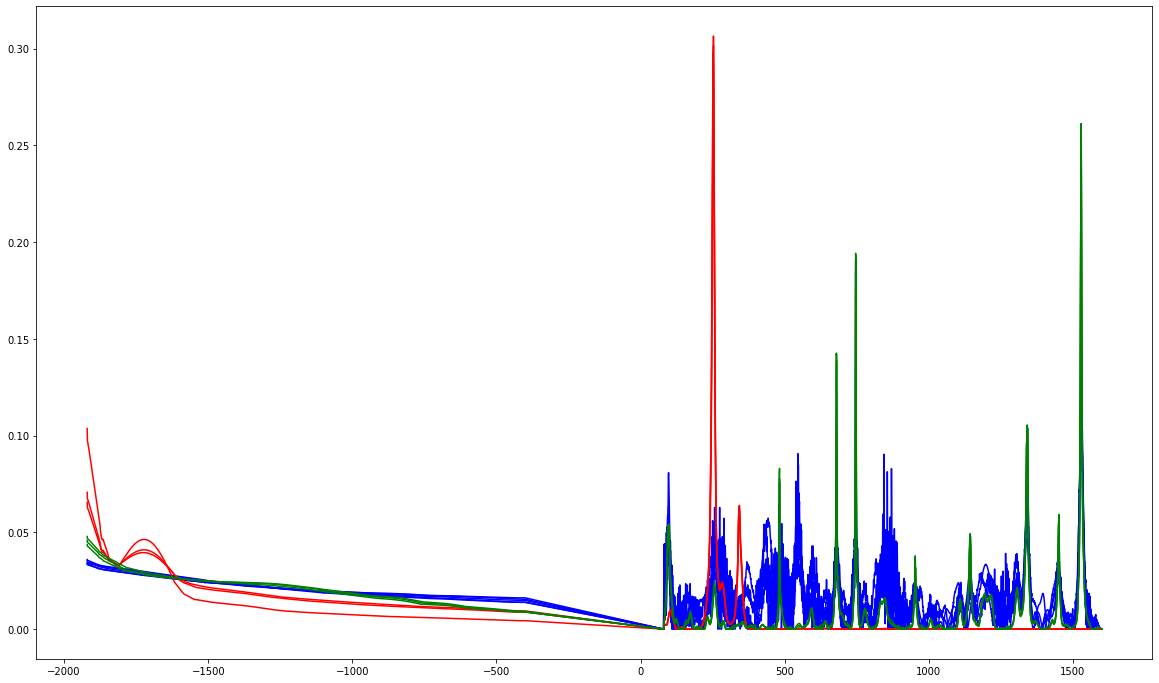

In [6]:
plt.figure(figsize = (20,12))
for s in blue:
    plt.plot(wave, s, 'b')
    
for s in red:
    plt.plot(wave, s, 'r')
    
for s in green:
    plt.plot(wave, s, 'g')

plt.show()

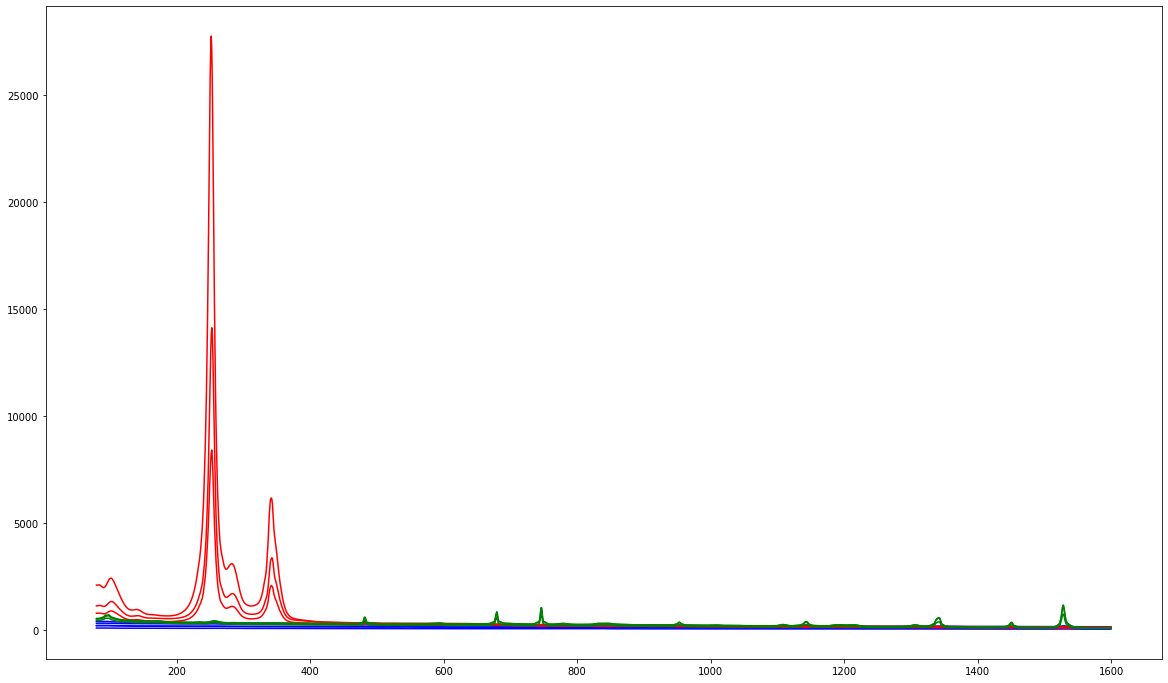

In [7]:
plt.figure(figsize = (20,12))

for s in b:
    plt.plot(wavelength, s, 'b')
                
for s in r:
    plt.plot(wavelength, s, 'r')
    
for s in g:
    plt.plot(wavelength, s, 'g')

plt.show()

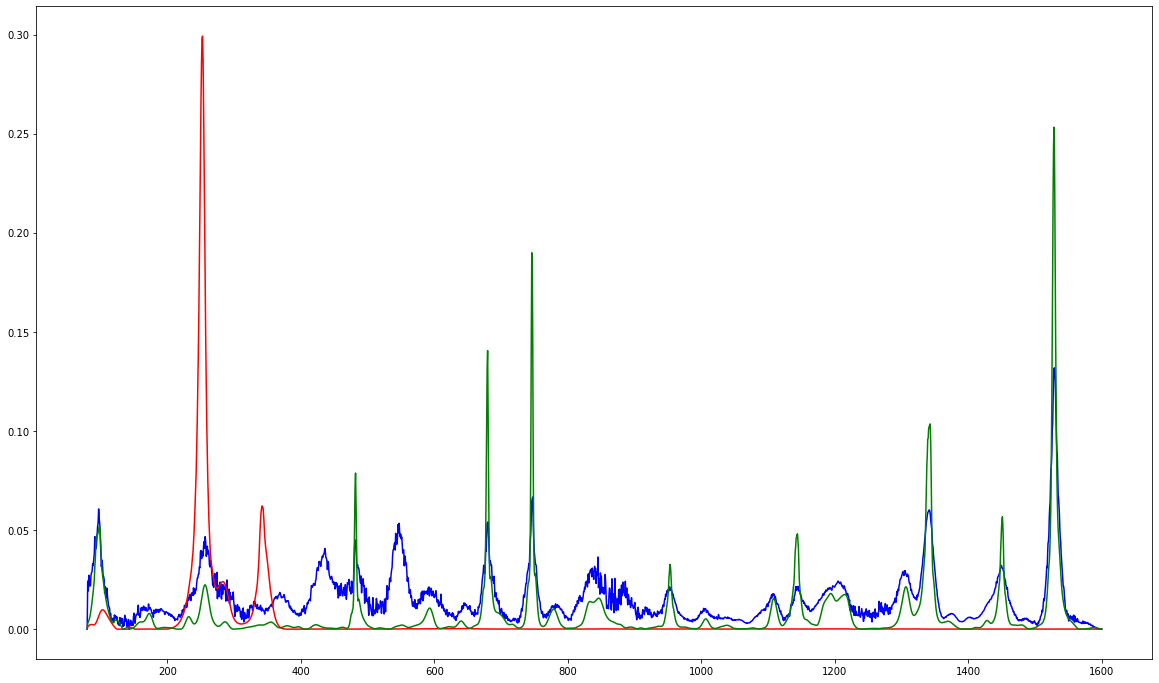

In [20]:
plt.figure(figsize = (20,12))

plt.plot(wave[2126:], avg_b[2126:], 'b')         
plt.plot(wave[2126:], avg_r[2126:], 'r')
plt.plot(wave[2126:], avg_g[2126:], 'g')

plt.show()

In [9]:
N_WAVE = 2126 * 2

# X = np.load("../data/Raman/Alina_art_1_1.npy", 'r')
Y = np.load("../data/Raman/Alina_Art_4_2.npy", 'r')

# shape_X = X.shape 
shape_Y = Y.shape

# X = copy.copy(X.reshape(-1, X.shape[-1]))
Y = copy.copy(Y.reshape(-1, Y.shape[-1]))

# ram_X, afl_X = split_Raman_af(X)
# ram_smooth_X = smoothing(ram_X, s)

Y = smoothing(Y, 5, 2)
ram_smooth_Y, fluor_smooth = split_Raman_af(Y)

data = np.hstack((unit_vector_norm(fluor_smooth), unit_vector_norm(ram_smooth_Y)))


In [10]:
class ReferenceVectorClassifier(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        
    def fit(self):
        self.reference_spectra_ = self.kwargs['ref']
    
    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """

        # Input validation
        X = unit_vector_norm(X)
        
        ###################### RCA ################################           
        RCA_vector = np.array([optimize.nnls(self.reference_spectra_.T, X[i,:])[0] for i in range(X.shape[0])])

        return RCA_vector
    
    def get_reference_vectors(self):
        return self.reference_spectra_  
    
    def get_params(self, deep=False):
        return self.kwargs

In [11]:
def error_map(estimator, X, y=None):
    RCA = estimator.predict(X)
    ref_vec = estimator.get_reference_vectors()
    return ((RCA @ ref_vec - X)**2).mean(1)

def score_func(estimator, X, y=None):
    X = unit_vector_norm(X)
    return error_map(estimator, X).mean()

def print_mean_std(X):
    return f"{X.mean():<12.4e}{X.std():<12.4e}"

def cross_val_X_Y_Z(rvc, X, Y, Z):
    rvc.fit(np.concatenate((X, Y), axis=0))
    return score_func(rvc, Z)

In [12]:
kwargs = {
    'ref' : np.array([avg_r, avg_g, avg_b]),
    'n_components': 3 
}

In [13]:
rvc = ReferenceVectorClassifier(**kwargs)
rvc.fit()

fit score:  9.893625449305836e-06


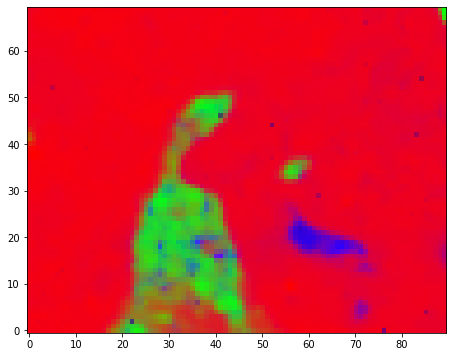

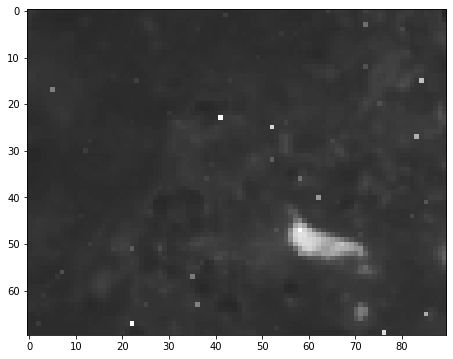

In [14]:
RCA_vector = rvc.predict(data)

print("fit score: ", score_func(rvc, data))
RCA_vector = RCA_vector - RCA_vector.min(0)
RCA_vector /= RCA_vector.max(0)

plt.figure(figsize = (20,6))
plt.imshow(RCA_vector.reshape((*shape_Y[:2], kwargs['n_components']))[::-1,:,:3])
plt.gca().invert_yaxis()
plt.show()
plt.figure(figsize = (20,6))
plt.imshow(error_map(rvc, data).reshape(shape_Y[:2]), cmap='gray', vmin=0)
plt.show()